In [1]:
from env.finger import Finger

from nets.nets import (
    StateEncoder,
    ActionEncoder,
    TransitionModel,
    StateDecoder,
    ActionDecoder,
)

from nets.inference import encode_state, encode_action, infer_states, decode_action, decode_state

from learning.eval_actor import eval_batch_actor

from policy.actor_policy import ActorPolicy

from learning.train_config import TrainConfig
from learning.train_state import TrainState, NetState

import jax
from jax.tree_util import Partial
import jax.numpy as jnp
import optax

import jax.experimental.host_callback

from einops import einops, einsum, rearrange
import matplotlib.pyplot as plt

import orbax.checkpoint as ocp

from pathlib import Path

import os

%matplotlib inline

In [2]:
learning_rate = 1e-4

latent_state_dim = 6
latent_action_dim = 2

env_cls = Finger

env_config = env_cls.get_config()

seed = 0
key = jax.random.PRNGKey(seed)

train_config = TrainConfig.init(
    learning_rate=learning_rate,
    optimizer=optax.chain(
        optax.zero_nans(),
        optax.lion(
            learning_rate=optax.cosine_onecycle_schedule(
                transition_steps=8192,
                peak_value=learning_rate,
                pct_start=0.3,
                div_factor=10.0,
                final_div_factor=1.0,
            )
        ),
    ),
    state_encoder=StateEncoder(latent_state_dim=latent_state_dim),
    action_encoder=ActionEncoder(latent_action_dim=latent_action_dim),
    transition_model=TransitionModel(
        latent_state_dim=latent_state_dim, n_layers=8, latent_dim=64, heads=4
    ),
    state_decoder=StateDecoder(state_dim=env_config.state_dim),
    action_decoder=ActionDecoder(act_dim=env_config.act_dim),
    latent_state_dim=latent_state_dim,
    latent_action_dim=latent_action_dim,
    env_config=env_config,
    env_cls=env_cls,
    seed=seed,
    target_net_tau=0.005,
    rollouts=256,
    epochs=256,
    batch_size=32,
    traj_per_rollout=512,
    rollout_length=64,
    state_radius=1.375,
    action_radius=2.0,
    reconstruction_weight=10.0,
    forward_weight=1.0,
    smoothness_weight=1.0,
    condensation_weight=1.0,
    dispersion_weight=1.0,
    forward_gate_sharpness=1,
    smoothness_gate_sharpness=1,
    dispersion_gate_sharpness=1,
    condensation_gate_sharpness=1,
    forward_gate_center=-9,
    smoothness_gate_center=-9,
    dispersion_gate_center=-9,
    condensation_gate_center=100,
)

checkpoint_dir = Path("checkpoints/")

checkpointer = ocp.PyTreeCheckpointer()

In [3]:
rng, key = jax.random.split(key)
train_state = TrainState.init(rng, train_config)

train_state = checkpointer.restore(
    (checkpoint_dir / "checkpoint_r52_s106496").absolute(), item=train_state
)

## Actually run the actor evals, this will take a while

In [4]:
policy = ActorPolicy.init(
    big_step_size=0.5,
    big_steps=16384,
    small_step_size=0.000001,
    small_steps=16384,
    big_post_steps=64,
    small_post_steps=64,
)
policy_aux = policy.make_aux(target_q=1.0)

In [5]:
start_state = env_cls.init()

## Optimize us some actions

In [6]:
rng, key = jax.random.split(key)
(optimized_actions, aux), infos, costs = jax.jit(policy.make_init_carry)(
    key=rng,
    start_state=start_state,
    aux=policy_aux,
    net_state=train_state.target_net_state,
    train_config=train_state.train_config,
)

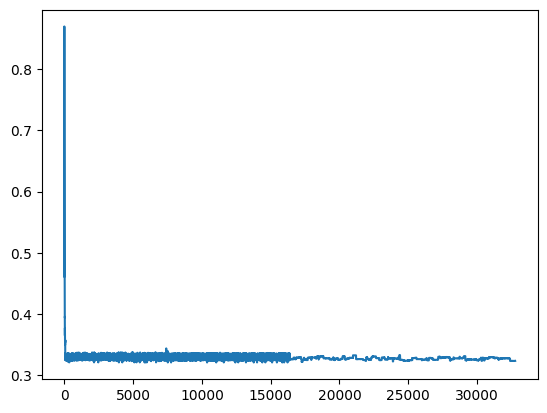

In [7]:
plt.plot(costs)

## Now let's see what the actor thinks would happen

In [8]:
rng, key = jax.random.split(key)
latent_start_state = encode_state(
    rng, start_state, train_state.target_net_state, train_state.train_config
)
expected_latent_states = jax.jit(infer_states)(rng, latent_start_state, optimized_actions, train_state.target_net_state, train_state.train_config)

In [9]:
rng, key = jax.random.split(key)
rngs = jax.random.split(rng, expected_latent_states.shape[0])
expected_states = jax.jit(
    jax.vmap(
        Partial(
            decode_state,
            net_state=train_state.target_net_state,
            train_config=train_state.train_config,
        )
    )
)(rngs, expected_latent_states)

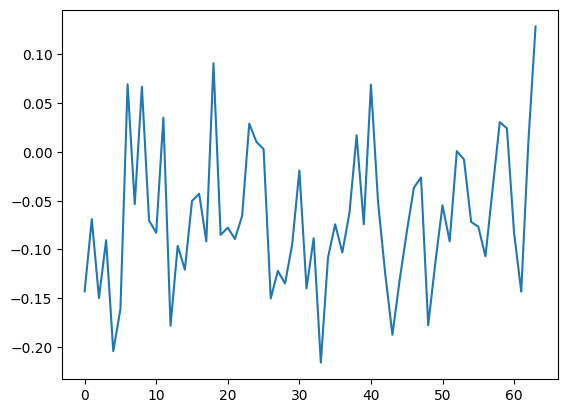

In [10]:
plt.plot(expected_states[..., 2])

In [11]:
import mediapy as media

media.show_video(
    env_cls.host_make_video(
        expected_states, train_state.train_config.env_config, dense=False
    ).transpose(0, 2, 3, 1)
)

## Roll out the policy in the environment

In [12]:
def scanf(carry, key):
    """Scans to collect a single rollout of physics data."""
    state, i, policy_carry = carry

    rng, key = jax.random.split(key)
    action, policy_carry, policy_info = policy(
        key=rng,
        state=state,
        i=i,
        carry=policy_carry,
        net_state=train_state.target_net_state,
        train_config=train_state.train_config,
    )
    action = jnp.clip(
        action,
        a_min=train_config.env_config.action_bounds[..., 0],
        a_max=train_config.env_config.action_bounds[..., -1],
    )
    next_state, dense_states = train_config.env_cls.step(
        state, action, train_config.env_config
    )

    return (next_state, i + 1, policy_carry), (
        (state, action),
        dense_states,
        policy_info,
    )

rng, key = jax.random.split(key)
scan_rngs = jax.random.split(rng, train_config.rollout_length - 1)
_, ((states, actions), dense_states, policy_info) = jax.lax.scan(
    scanf,
    (start_state, 0, (optimized_actions, aux)),
    scan_rngs,
)

dense_states = rearrange(dense_states, "t u s -> (t u) s")

dense_states = jnp.concatenate([start_state[None], dense_states])
states = jnp.concatenate([states, start_state[None]])

dense_actions = jnp.repeat(actions, 32, axis=0)

In [13]:
rng, key = jax.random.split(key)
rngs = jax.random.split(rng, states.shape[0])
latent_states = jax.vmap(
    Partial(
        encode_state,
        net_state=train_state.target_net_state,
        train_config=train_state.train_config,
    ),
)(key=rngs, state=states)

rng, key = jax.random.split(key)
rngs = jax.random.split(rng, dense_states.shape[0])
dense_latent_states = jax.vmap(
    Partial(
        encode_state,
        net_state=train_state.target_net_state,
        train_config=train_state.train_config,
    ),
)(key=rngs, state=dense_states)

In [14]:
rng, key = jax.random.split(key)
rngs = jax.random.split(rng, actions.shape[0])
latent_actions = jax.vmap(
    Partial(
        encode_action,
        net_state=train_state.target_net_state,
        train_config=train_state.train_config,
    )
)(key=rngs, action=actions, latent_state=latent_states[:-1])


rng, key = jax.random.split(key)
rngs = jax.random.split(rng, dense_actions.shape[0])
dense_latent_actions = jax.vmap(
    Partial(
        encode_action,
        net_state=train_state.target_net_state,
        train_config=train_state.train_config,
    )
)(key=rngs, action=dense_actions, latent_state=dense_latent_states[:-1])

In [15]:
rng, key = jax.random.split(key)
inferred_latent_states = infer_states(
    key=rng,
    latent_start_state=latent_states[0],
    latent_actions=latent_actions,
    net_state=train_state.target_net_state,
    train_config=train_state.train_config,
    current_action_i=0,
)

In [16]:
diffs = inferred_latent_states - latent_states[1:]
diff_norms = jnp.linalg.norm(diffs, ord=1, axis=-1)

In [17]:
print(jnp.mean(diff_norms))

0.36109322


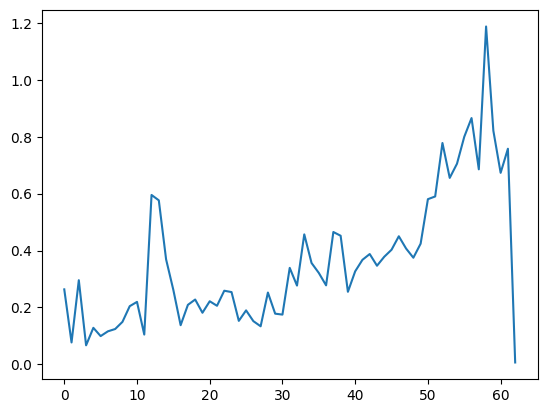

In [18]:
plt.plot(diff_norms)

In [19]:
rng, key = jax.random.split(key)
rngs = jax.random.split(rng, inferred_latent_states.shape[0])

media.show_video(
    env_cls.host_make_video(
        # jax.vmap(
        #     Partial(
        #         decode_state,
        #         net_state=train_state.target_net_state,
        #         train_config=train_state.train_config,
        #     )
        # )(key=rngs, latent_state=inferred_latent_states),
        dense_states,
        env_config=train_state.train_config.env_config,
        dense=True,
    ).transpose([0, 2, 3, 1])
)

## Let's make a scatterplot of all of the latent states and actions the algorithm decided on

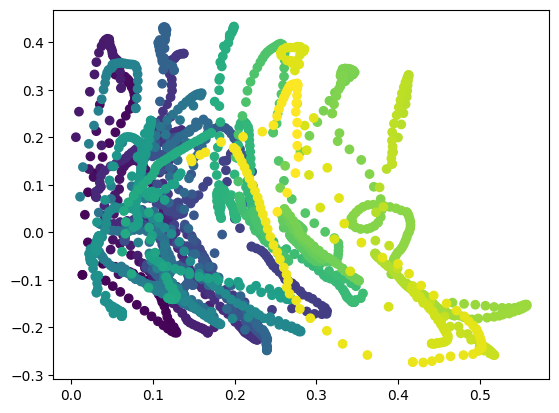

In [20]:
import numpy as np

plt.scatter(
    dense_latent_states[..., 4],
    dense_latent_states[..., 5],
    c=range(dense_latent_states.shape[0]),
    cmap="viridis",
)

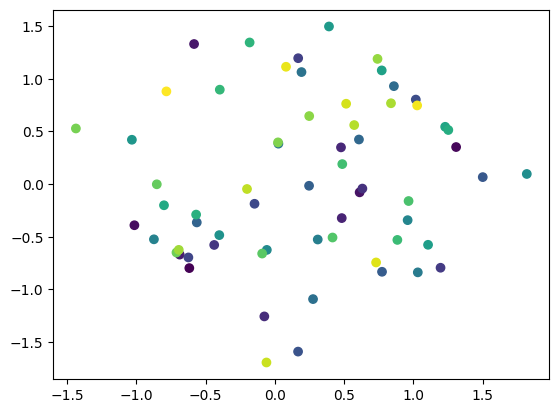

In [21]:
plt.scatter(optimized_actions[..., 0], optimized_actions[..., 1], c=range(len(optimized_actions)), cmap="viridis")

## Let's plot the achieved final costs

In [22]:
# plt.hist(info.plain_infos['final_cost'])

## Let's visualize what the algorithm did

In [23]:
import mediapy as media

video = env_cls.host_make_video(dense_states, env_config).transpose(0, 2, 3, 1)
media.show_video(video, fps=24)

## Let's investigate what action space actions are available from the start state

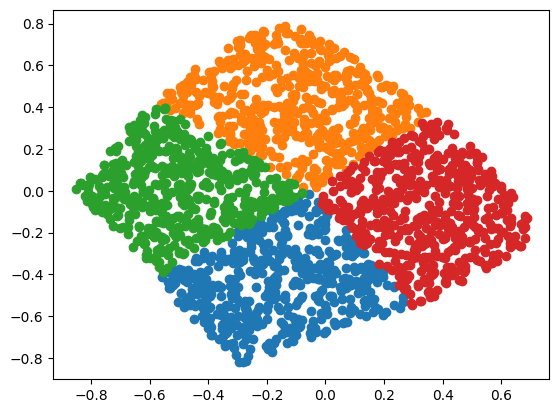

In [31]:
sample_count = 512
rng, key = jax.random.split(key)
# action_samples = (
#     jax.random.ball(rng, d=train_state.train_config.latent_action_dim, p=1, shape=[sample_count])
#     * train_state.train_config.action_radius
# )

action_samples = (
    jax.random.ball(
        rng, d=train_state.train_config.latent_action_dim, p=1, shape=[4, sample_count]
    )
    * 1.0
) + jnp.array([[-1, 0], [1, 0], [0, -1], [0, 1]])[:, None, :]


rng, key = jax.random.split(key)
rngs = jax.random.split(rng, [4, sample_count])
action_space_actions = jax.vmap(
    jax.vmap(
        jax.tree_util.Partial(
            decode_action,
            latent_state=latent_states[12],
            net_state=train_state.target_net_state,
            train_config=train_state.train_config,
        )
    )
)(rngs, action_samples)

# plt.scatter(x=action_samples[..., 0], y=action_samples[..., 1])
for i in range(4):
    plt.scatter(x=action_space_actions[i, ..., 0], y=action_space_actions[i, ..., 1])

# set lims
# plt.xlim(-10, 10)
# plt.ylim(-10, 10)